## Plot results for catepillar tree

Mamie Wang 2020/10/14



Test run time and accuracy against the length of sequences for caterpillar tree of size 512. 

Scripts: `sbatch --array = `
List of experiments: `../test_catepillar_tree.lst`

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns
from matplotlib import cm

In [2]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import generation
import reconstruct_tree
import time
import utils
import pandas as pd
import argparse

# Find suitable parameters for caterpillar trees
tree_size = 512
tree = utils.lopsided_tree(tree_size)

In [14]:
m = 800
mutation_rate = 0.01
kappa = 2
observations, taxa_meta = generation.simulate_sequences(m, tree_model=tree, seq_model=generation.HKY(kappa = kappa), 
                                                        mutation_rate=mutation_rate, alphabet="DNA")


In [16]:
threshold = 64
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.HKY_similarity_matrix,
                                                            taxa_metadata = taxa_meta,
                                                            threshhold = threshold, min_split = 5, verbose = False)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)


64
--- 20.827547073364258 seconds ---
RF =  4
F1% =  99.80430528375734


In [17]:
nj = reconstruct_tree.NeighborJoining(reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = nj(observations, taxa_meta)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)

64
--- 39.71326780319214 seconds ---
RF =  572
F1% =  72.01565557729941


In [51]:
# write out list of parameters to run

m = [400, 600, 800, 1000, 1200]
tree_type = "caterpillar"
method = ["NJ", "SNJ", "RAxML", 
          "STDR+NJ", "STDR+NJ", "STDR+NJ", 
          "STDR+SNJ", "STDR+SNJ", "STDR+SNJ", 
          "STDR+RAxML", "STDR+RAxML", "STDR+RAxML"]
nrun = 5
size = 512
path = "None"
threshold = [0] * 15 + list(np.repeat([256, 128, 64] * 3, 5))
kappa = 2
mutation_rate = 0.05
verbose = True
m_lst = np.tile(m, 12)

In [53]:
par_list = pd.DataFrame({"type": tree_type, "method": np.repeat(method, 5), 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m_lst, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [55]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_caterpillar_tree.lst", 
                sep = "\t",  index = False)

In [2]:
def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

In [3]:
paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_m*")

metrics, summarized = summarize_perf(paths)
summarized

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


runtime              RF              F1      
                         mean     std    mean     std    mean   std
m    method                                                        
400  STDR+RAxML (64)    79.17    0.87     0.0    0.00  100.00  0.00
     STDR+RAxML (128)   90.77   12.31     0.4    0.89   99.98  0.04
     STDR+SNJ (64)      21.84    0.16     5.2    1.10   99.75  0.05
     STDR+SNJ (128)     24.09    0.95    12.0    5.10   99.41  0.25
     STDR+SNJ (256)     36.61    3.31    20.8   12.93   98.98  0.63
     SNJ               312.27   34.28    32.4    8.41   98.41  0.41
     STDR+NJ (64)       19.50    0.15    83.6   48.90   95.91  2.39
     STDR+RAxML (256)   96.97    7.58   187.6   50.60   90.82  2.48
     STDR+NJ (128)      23.66    0.31   397.2   69.99   80.57  3.42
     STDR+NJ (256)      25.14    0.26   730.4   46.89   64.27  2.29
     RAxML             163.49   57.62   772.0   77.50   62.23  3.79
     NJ                 42.70    0.23   968.8   47.17   52.60  2.31
600  STDR+RAxML (64)   104.91    1.14     0.0    0.00  100.00  0.00
     STDR+SNJ (64)      24.78    0.54     0.8    1.10   99.96  0.05
     STDR+SNJ (128)     25.01    0.50     0.8    1.10   99.96  0.05
     STDR+SNJ (256)     41.36    2.05     0.8    1.79   99.96  0.09
     SNJ               300.89   34.50     2.8    2.28   99.86  0.11
     STDR+NJ (64)       21.81    0.22    62.0   20.59   96.97  1.01
     STDR+RAxML (128)  113.66    8.36    63.2   86.96   96.91  4.25
     STDR+RAxML (256)  134.74    6.09   230.4   69.40   88.73  3.40
     STDR+NJ (128)      22.23    0.26   366.4   40.33   82.07  1.97
     STDR+NJ (256)      25.66    1.33   732.8  114.65   64.15  5.61
     RAxML             198.21   44.08   751.6  106.16   63.23  5.19
     NJ                 45.89    0.29  1000.4    7.92   51.06  0.39
800  STDR+SNJ (64)      23.50    0.19     0.0    0.00  100.00  0.00
     STDR+RAxML (64)   132.19    1.94     0.0    0.00  100.00  0.00
     STDR+RAxML (128)  142.69    0.68     0.0    0.00  100.00  0.00
     STDR+SNJ (128)     26.70    0.68     0.4    0.89   99.98  0.04
     STDR+SNJ (256)     42.16    3.79     0.4    0.89   99.98  0.04
     SNJ               317.43   35.41     0.8    1.10   99.96  0.05
     STDR+NJ (64)       23.38    0.20    52.0   22.14   97.46  1.08
     STDR+RAxML (256)  172.79   50.27   227.2   59.78   88.88  2.92
     STDR+NJ (128)      25.72    0.19   362.0   16.49   82.29  0.81
     STDR+NJ (256)      26.61    0.32   711.6   48.57   65.19  2.38
     RAxML             298.18   75.20   819.6  114.99   59.90  5.63
     NJ                 44.83    1.73  1005.2    3.35   50.82  0.16
1000 STDR+SNJ (64)      23.87    0.95     0.0    0.00  100.00  0.00
     STDR+SNJ (128)     27.07    1.19     0.0    0.00  100.00  0.00
     STDR+SNJ (256)     39.15    2.41     0.0    0.00  100.00  0.00
     STDR+RAxML (64)   160.12    1.84     0.0    0.00  100.00  0.00
     STDR+RAxML (128)  180.58   17.60     0.0    0.00  100.00  0.00
     SNJ               314.08   44.10     0.0    0.00  100.00  0.00
     STDR+NJ (64)       24.35    0.15    43.2   19.83   97.89  0.97
     STDR+RAxML (256)  214.34   50.40    94.0  129.74   95.40  6.35
     STDR+NJ (128)      24.50    0.24   301.6   25.74   85.24  1.26
     STDR+NJ (256)      24.15    0.82   680.4   68.24   66.71  3.34
     RAxML             344.57  105.06   766.0  105.48   62.52  5.16
     NJ                 47.70    0.18   961.6   61.62   52.95  3.01
1200 STDR+SNJ (64)      26.14    0.81     0.0    0.00  100.00  0.00
     STDR+SNJ (128)     29.45    1.44     0.0    0.00  100.00  0.00
     STDR+SNJ (256)     43.00    4.52     0.0    0.00  100.00  0.00
     STDR+RAxML (64)   184.28    3.25     0.0    0.00  100.00  0.00
     STDR+RAxML (128)  200.89    7.01     0.0    0.00  100.00  0.00
     SNJ               312.19   39.30     0.0    0.00  100.00  0.00
     STDR+NJ (64)       24.87    0.49    26.0   15.62   98.73  0.76
     STDR+RAxML (256)  280.30   74.87   148.4  143.09   92.74  7.00
     STDR+

In [4]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

In [88]:
ordering = ["RAxML", "STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", 
            "NJ", "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", 
            "SNJ", "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))

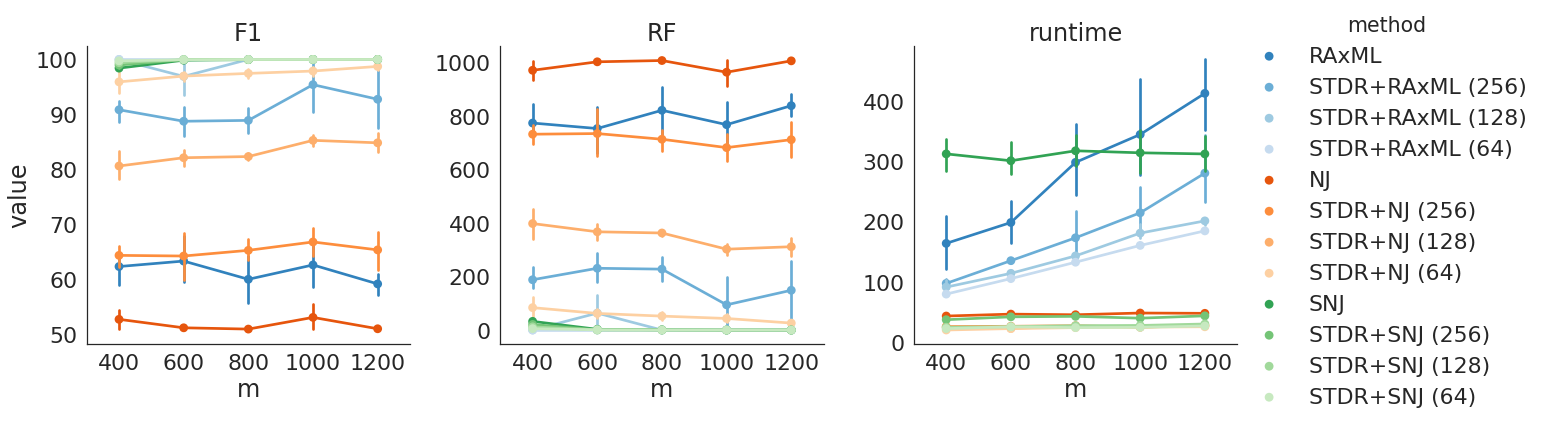

In [90]:
sns.set(style = "white", font_scale = 2)
sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6, palette = color_dict).set_titles("{col_name}")

In [4]:
import glob
import pandas as pd
import re
from matplotlib import cm

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]


import numpy as np
ordering = [ "STDR+RAxML (64)", "RAxML", "STDR+NJ (64)","NJ",  "STDR+SNJ (64)", "SNJ"]

selected = np.isin(df_long.method, ordering)

df_long = df_long.iloc[selected,:]


df_long.loc[df_long.performance == "F1","performance"] = "F1 score (%)"
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

color_dict = dict(zip(ordering, np.array([colors[i] for i in [0,1,4,5,8,9]])))

import seaborn as sns

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6, 
                palette = color_dict, margin_titles = False, sizes = 20, markers = ["s", "X", "^", "o", "+", "*"], linestyles=["-", "--", "-", "--", "-", "--"])

labels = ["F1 score (%)", "RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
g.set_titles("")
g.set_xlabels("Number of samples (n)")

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


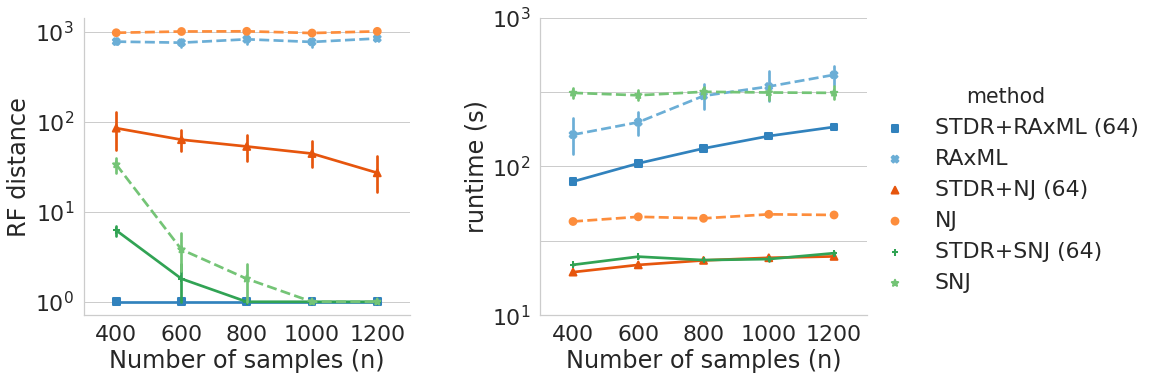

In [9]:
import glob
import pandas as pd
import re
from matplotlib import cm

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (64)", "RAxML", "STDR+NJ (64)","NJ",  "STDR+SNJ (64)", "SNJ"]

selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")


df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] + 1
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

color_dict = dict(zip(ordering, np.array([colors[i] for i in [0,1,4,5,8,9]])))

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, markers = ["s", "X", "^", "o", "+", "*"], linestyles=["-", "--", "-", "--", "-", "--"], 
                legend_out= True, gridspec_kws={"wspace":0.4})

labels = ["RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    ax.set(yscale="log")
    if i == 1:
        ax.set(ylim=(10, 1000))
        ax.set_yticks([10, 10**1.5, 10**2, 10**2.5, 10**3])
g.set_titles("")
g.set_xlabels("Number of samples (n)")

plt.subplots_adjust(wspace = 0.4)
plt.savefig("caterpillar_performance.eps")
plt.minorticks_on()